## Implement Baselines
To fit our baseline model we will use OLS(ordinary least squares regression). We will split our dataset into a train and test and run 10 linear regression to calculate the train and test score.

In [15]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
import xgboost as xgb
from xgboost import plot_importance
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
cols = [
    'id',
    'log_price',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'bed_type',
    'number_of_reviews',
    'review_scores_rating',
    'bathrooms',
    'cancellation_policy',
    'cleaning_fee',
    'host_response_rate',
    'host_has_profile_pic',
    'host_identity_verified',
    'instant_bookable'    
]
data = pd.read_csv("CA.csv",usecols = cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20071 entries, 0 to 20070
Data columns (total 19 columns):
id                        20071 non-null int64
log_price                 20071 non-null float64
property_type             20071 non-null object
room_type                 20071 non-null object
accommodates              20071 non-null int64
bathrooms                 20071 non-null float64
bed_type                  20071 non-null object
cancellation_policy       20071 non-null object
cleaning_fee              20071 non-null bool
host_has_profile_pic      20071 non-null object
host_identity_verified    20071 non-null object
host_response_rate        20071 non-null object
instant_bookable          20071 non-null object
latitude                  20071 non-null float64
longitude                 20071 non-null float64
number_of_reviews         20071 non-null int64
review_scores_rating      20071 non-null object
bedrooms                  20071 non-null float64
beds                      2

Our dataset is now clean and we no longer have any missing values. We have a total of 20,071 records from the original dataset; thus, we've retained a reasonable amount of records. We have a few columns that contain categorical predictors. The regressors in scikit learn require numeric fields; thus we will use the get_dummies routine in Pandas to convert these into 'dummy' variables (one hot encoding); i.e we will add a column for every possible value of the field. We will standardize the non-categorical predictors and convert them to floating point values since we will later try linear regression models such as Ridge and Lasso regression.

In [3]:
#encode the categorical variables
property_dummies = pd.get_dummies(data['property_type'])
#zipcode_dummies = pd.get_dummies(data['zipcode'])
room_dummies = pd.get_dummies(data['room_type'])
bed_dummies = pd.get_dummies(data['bed_type'])
ratings_scores_dummies = pd.get_dummies(data['review_scores_rating'])
cancel_dummy = pd.get_dummies(data['cancellation_policy'])
cleaning_dummy = pd.get_dummies(data['cleaning_fee'])
profile_dummy = pd.get_dummies(data['host_has_profile_pic'])
host_identify_dummy = pd.get_dummies(data['host_identity_verified'])
host_response_dummy = pd.get_dummies(data['host_response_rate'])
bookable_dummy = pd.get_dummies(data['instant_bookable'])
##replace the old columns with new one-hot encoded ones
df = pd.concat((data.drop(['property_type','room_type', 'bed_type', 'review_scores_rating','cancellation_policy',\
                          'cleaning_fee','host_has_profile_pic','host_identity_verified','host_response_rate','instant_bookable'],axis = 1),\
               property_dummies.astype(int),room_dummies,bed_dummies.astype(int),ratings_scores_dummies.astype(int),cancel_dummy.astype(int),\
                cleaning_dummy.astype(int),profile_dummy.astype(int),host_identify_dummy.astype(int),host_response_dummy.astype(int),bookable_dummy.astype(int)),axis = 1)
print('Number of Columns:',len(df.columns))

Number of Columns: 71


In [4]:
df = pd.get_dummies(data)

In [5]:
#move the target predictor log_price to the end of the columns
cols = list(df.columns.values)
idx = cols.index('log_price')
rearrange_cols = cols[:idx]+cols[idx+1:]+[cols[idx]]
df = df[rearrange_cols]

In [6]:
#move the target predictor log_price to the end of the columns
cols = list(data.columns.values)
idx = cols.index('log_price')
rearrange_cols = cols[:idx]+cols[idx+1:]+[cols[idx]]
data = data[rearrange_cols]

In [7]:
#convert the non-categorical variables to floats and standardize it
def standard_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x-mean)/std)
non_categorical = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews','bathrooms','latitude','longitude']
for col in non_categorical:
    df[col] = df[col].astype(float)
    df[col] = standard_col(df[col])
    
df.head()

,id,accommodates,bathrooms,cleaning_fee,latitude,longitude,number_of_reviews,bedrooms,beds,property_type_Apartment,...,instant_bookable_f,instant_bookable_t,review_scores_rating_10,review_scores_rating_5,review_scores_rating_6,review_scores_rating_7,review_scores_rating_8,review_scores_rating_9,review_scores_rating_No Review,log_price
0,11825529,-0.185483,-0.468282,True,-0.728090,-0.833806,-0.201275,-0.348686,-0.594569,1,...,0,1,0,0,0,0,0,1,0,4.418841
1,13971273,-0.588779,-0.468282,True,-0.088846,0.463018,-0.353043,-0.348686,-0.594569,0,...,1,0,0,0,0,0,0,1,0,4.787492
2,5385260,-0.588779,-0.468282,True,-0.611313,2.798296,-0.530106,-0.348686,-0.594569,0,...,0,1,0,0,0,0,0,1,0,3.583519
3,17423675,0.217813,0.188845,True,-1.736793,-0.452361,0.152851,0.683995,0.073045,0,...,1,0,0,0,0,0,0,1,0,5.010635
4,14066228,-0.588779,-0.468282,True,-2.340845,-0.363555,-0.580696,-0.348686,-0.594569,1,...,1,0,0,0,0,0,0,0,1,4.248495


In [8]:
x = df.iloc[:,2:-1]
y = df.iloc[:,-1]

In [9]:
x_train,x_validate,y_train,y_validate = train_test_split(x,y,test_size = 0.3,random_state = 123)

## XGBoost

In [10]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(x_train,y_train)
training_preds_xgb_reg = xgb_reg.predict(x_train)
val_preds_xgb_reg = xgb_reg.predict(x_validate)
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_validate, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_validate, val_preds_xgb_reg),4))


Training MSE: 0.1481
Validation MSE: 0.1574

Training r2: 0.731
Validation r2: 0.7206


In [11]:
#see the feature importance
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_,columns=['weight'],index = x_train.columns)
ft_weights_xgb_reg.sort_values('weight',inplace = True)

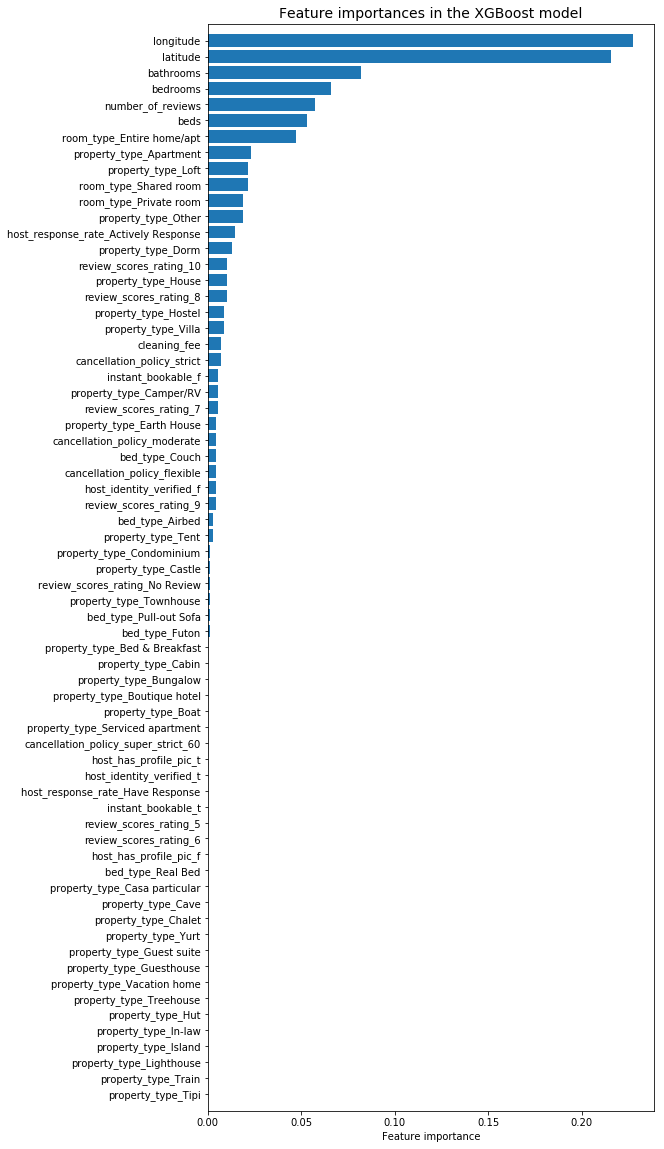

In [12]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## Three layer neural network

In [13]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

NameError: name 'models' is not defined